<img src="./img/logos_combined.png" align="right" width="50%"></img>
<br><br><br>

<hr>

## Example: Create a climate graph for Reading

A climate graph is commonly used to describe the average weather of one specific location. It contains:
* the <b>long-term average, minimum and maximum air temperature</b> for each month
* the <b>long-term average precipitation</b> for each month

<br>

<img src="./img/climate_graph_reading.png" align="centre" width="80%"></img>

<br><br>


### Data required


ERA-Interim reanalysis - 2m air temperature and total precipitation from 1 January 1979 to 31 December 2014
* Format: GRIB
* Spatial resolution: Lat/Lon grid, 0.5 x 0.5 degrees, 720 x 361 gridpoints
* Temporal resolution: 6-hourly
* Data volume: 27 GB per parameter

<br>

### Workflow

(1) Retrieve monthly mean, min and max 2m air temperature from Jan 1979 to Dec 2014

(2) Retrieve monthly sums of total precipitation from Jan 1979 to Dec 2014

(3) Calculate averages for every month for every parameter

(4) Plot the climate graph



#### Load required libraries

In [1]:
%matplotlib inline
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import collections

#### Define the WCPS query

With one WCPS request,
* the data can be converted into a different unit, e.g. from Kelvin to degree Celsius, and
* a mathematical condenser, e.g. average, minimum or maximum, can be applied to the data values retrieved


In [2]:
# WCPS query format for 2m air temperature (conversion of Kelvin to degree Celsius)
url_fmt_temp = 'http://earthserver.ecmwf.int/rasdaman/ows?service=WCS&version=2.0.1' \
          '&request=ProcessCoverages' \
          '&query=for c in (%s) return encode(%s(c[Lat(%d:%d), Long(%d:%d),ansi("%s":"%s")] - 273.15), "csv")'

# WCPS query format for total precipitation (conversion from m of water to mm of water)
url_fmt_precip = 'http://earthserver.ecmwf.int/rasdaman/ows?service=WCS&version=2.0.1' \
          '&request=ProcessCoverages' \
          '&query=for c in (%s) return encode(%s(c[Lat(%d:%d), Long(%d:%d),ansi("%s":"%s")] * 1000), "csv")'

#### Helper functions


In [3]:
# A list for every first day in the month from Jan 1979 to Dec 2014
startDateList = (range(432))
x =datetime(1979,1,1,0)
for i in range(0,len(startDateList)):
    startDateList[i]=x
    x=(x.replace(day=1)+timedelta(days=31)).replace(day=1)

# A list with every last day of the month from Jan 1979 to Dec 2014
endDateList = (range(432))
for i in range(0, len(endDateList)):
    y = startDateList[i].replace(hour=18) + relativedelta(day=31)
    endDateList[i]=y

startDateListISO=(range(432))
for i in range(0,len(startDateListISO)):
    startDateListISO[i]=startDateList[i].date().isoformat()

#### Function to retrieve data from the Web Coverage Service

In [4]:
# Function that retrieves for every month all data values from the WCS server and appends the outputs to a python list
def retrieveFromWCS(param, operation, latMin, latMax, lonMin, lonMax):
    if param=="precipitation":
        startDateList[0]=startDateList[0] + timedelta(days=1)
        query = url_fmt_precip
    else:
        query = url_fmt_temp
    monthlyTS = []
    for i,j in zip(startDateList,endDateList):
        url = query % (param, operation, latMin,latMax,lonMin,lonMax,i.isoformat(),j.isoformat())
        r= requests.get(url,
                proxies={'http':None}
                )

        r.raise_for_status()
        y= [float(a) for a in r.text[0:-1].split(",")]
        monthlyTS.append(y[0])
    return monthlyTS

#### (1) Retrieve average, minimum and maximum surface temperature for Reading for every month

In [6]:
latMin = 51.27
latMax = 51.27
lonMin = -0.58
lonMax = -0.58
monthlyTS_avg = retrieveFromWCS("temp2m", "avg", latMin, latMax, lonMin, lonMax)
monthlyTS_max = retrieveFromWCS("temp2m", "max", latMin, latMax, lonMin, lonMax)
monthlyTS_min = retrieveFromWCS("temp2m", "min", latMin, latMax, lonMin, lonMax)

#### (2) Retrieve monthly sums of total precipitation for Reading for every month

In [8]:
latMin = 51.27
latMax = 51.27
lonMin = -0.58
lonMax = -0.58
monthlyTS_sum = retrieveFromWCS("precipitation", "add", latMin, latMax, lonMin, lonMax)

#### (3) Calculate averages for every month for every parameter

In [9]:
def calculateMonthlyAvgTS (inputArray):
    tmp = np.empty((12))
    for i in range(0,12):
        month = inputArray[i::12]
        tmp[i] = np.mean(month, axis=0)
    return tmp

monthsAvg = calculateMonthlyAvgTS(monthlyTS_avg)
monthsMax = calculateMonthlyAvgTS(monthlyTS_max)
monthsMin = calculateMonthlyAvgTS(monthlyTS_min)
monthsAvg_precip = calculateMonthlyAvgTS(monthlyTS_sum)

#### (4) Plot the climate graph for Reading

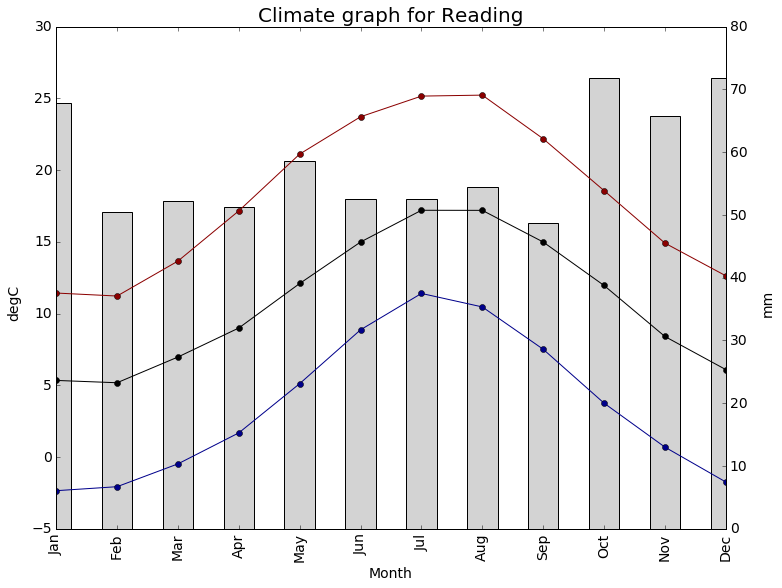

In [10]:
from ggplot import *
import pandas
import matplotlib.pyplot as plt

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
columns = ["temp_avg", "temp_max", "temp_min"]

df = pandas.DataFrame(months, columns=['Month'])
df['temp_avg'] = pandas.Series(monthsAvg, index=df.index)
df['temp_max'] = pandas.Series(monthsMax, index=df.index)
df['temp_min'] = pandas.Series(monthsMin, index=df.index)
df['precip_avg'] =pandas.Series(monthsAvg_precip, index=df.index)

ax1 = df[['Month','precip_avg']].plot(x='Month',kind='bar',color='#D3D3D3', legend=False, \
                                     figsize=(12,9), fontsize=12)

ax2 = ax1.twinx()
df[['Month', 'temp_avg']].plot(x='Month',linestyle='-',marker='o', ax=ax2,color='black', legend=False)
df[['Month', 'temp_max']].plot(x='Month', linestyle='-',marker='o',ax=ax2,color='darkred',legend=False)
df[['Month', 'temp_min']].plot(x='Month', linestyle='-',marker='o',ax=ax2,color='darkblue', legend=False)

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

ax1.set_title("Climate graph for Reading", fontsize=20)
ax1.set_xlabel("Month", fontsize=14)
ax2.set_ylabel("mm", labelpad=35, y=0.45, fontsize=14)
ax1.set_ylabel("degC", labelpad=35, y=0.45,fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)

plt.show()

<hr>

### [>> Index](./index.ipynb)

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>